# Load RU29 processed ADCP data and compute transect transports

## Imports

In [ ]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from scipy.interpolate import interp1d
import dbdreader
from scipy.ndimage import gaussian_filter

fontsize = 12

######################################################################

def calc_segment_transport(ds):
    segment_dist = np.empty(len(ds.time))
    segment_dist[:] = np.nan
    segment_transport = np.empty(len(ds.time))
    segment_transport[:] = np.nan
    dz = np.diff(ds.depth)[0]

    for x in np.arange(0,len(ds.time)):
        segment_dist[x] = geodesic((ds.start_lat[x],ds.start_lon[x]),(ds.end_lat[x],ds.end_lon[x])).meters
        segment_transport[x] = np.nansum(ds.u_grid[:,x]*segment_dist[x]*dz)
    
    ds["segment_transport"] = (("time"), segment_transport)
    ds["segment_dist"] = (("time"), segment_dist)

    return ds

######################################################################

def calc_segment_transport_interp(ds):
    segment_dist = np.empty(len(ds.latitude))
    segment_dist[:] = np.nan
    segment_transport = np.empty(len(ds.latitude))
    segment_transport[:] = np.nan
    dz = np.diff(ds.depth)[0]

    for x in np.arange(0,len(ds.latitude)):
        segment_dist[x] = geodesic((ds.start_lat[x],ds.start_lon[x]),(ds.end_lat[x],ds.end_lon[x])).meters
        segment_transport[x] = np.nansum(ds.u_grid[:,x]*segment_dist[x]*dz)
    
    ds["segment_transport"] = (("latitude"), segment_transport)
    ds["segment_dist"] = (("latitude"), segment_dist)

    return ds

######################################################################

def interpolate_all_profiles_to_lat_grid(ds, lat_grid, const_lon=-69.0):
    """
    Interpolates u_grid and v_grid from all profiles onto lat_grid.
    Saves start/end lat/lon, n_profs, and mean time per lat bin.

    Parameters:
        ds (xr.Dataset): input dataset with 'latitude' (time), 'u_grid', 'v_grid' (depth, time)
        lat_grid (1D array): latitude centers
        const_lon (float): constant longitude for output

    Returns:
        xr.Dataset with dims:
          - depth
          - latitude (interpolation grid)
        variables:
          - u_grid(depth, latitude)
          - v_grid(depth, latitude)
          - n_profs(latitude)
          - mean_time(latitude)  # mean time of profiles in each lat bin
          - start_lat(latitude)
          - end_lat(latitude)
          - start_lon(latitude)
          - end_lon(latitude)
          - longitude(latitude)
    """
    lats = ds['latitude'].values      # (time,)
    u = ds['u_grid'].values           # (depth, time)
    v = ds['v_grid'].values
    depth = ds['depth'].values
    time = ds['time'].values          # numpy datetime64 or numeric

    n_depth = len(depth)
    n_lat = len(lat_grid)

    u_interp = np.full((n_depth, n_lat), np.nan)
    v_interp = np.full((n_depth, n_lat), np.nan)

    # Bin edges
    bin_width = np.diff(lat_grid).mean() if len(lat_grid) > 1 else 0.05
    half_bin = bin_width / 2
    start_lat = lat_grid - half_bin
    end_lat = lat_grid + half_bin
    start_lon = np.full_like(lat_grid, const_lon)
    end_lon = np.full_like(lat_grid, const_lon)

    # Compute n_profs and mean_time per lat bin
    n_profs = np.empty(n_lat, dtype=int)
    mean_time = np.full(n_lat, np.nan, dtype='float64')

    for i, (s_lat, e_lat) in enumerate(zip(start_lat, end_lat)):
        in_bin_mask = (lats >= s_lat) & (lats < e_lat)
        n_profs[i] = np.sum(in_bin_mask)
        if n_profs[i] > 0:
            # Handle numeric or datetime64 time arrays
            times_in_bin = time[in_bin_mask]
            # If datetime64, convert to float for mean then back
            if np.issubdtype(time.dtype, np.datetime64):
                mean_ts = times_in_bin.astype('datetime64[ns]').astype('int64').mean()
                mean_time[i] = np.datetime64(int(mean_ts), 'ns').astype('float64')
            else:
                mean_time[i] = times_in_bin.mean()
        else:
            mean_time[i] = np.nan

    # Interpolate u, v at each depth across all valid profiles
    for i in range(n_depth):
        valid_mask = np.isfinite(lats) & np.isfinite(u[i, :]) & np.isfinite(v[i, :])
        if np.sum(valid_mask) < 2:
            continue

        lat_valid = lats[valid_mask]
        u_valid = u[i, valid_mask]
        v_valid = v[i, valid_mask]

        sort_idx = np.argsort(lat_valid)
        lat_sorted = lat_valid[sort_idx]
        u_sorted = u_valid[sort_idx]
        v_sorted = v_valid[sort_idx]

        f_u = interp1d(lat_sorted, u_sorted, bounds_error=False, fill_value=np.nan)
        f_v = interp1d(lat_sorted, v_sorted, bounds_error=False, fill_value=np.nan)

        u_interp[i, :] = f_u(lat_grid)
        v_interp[i, :] = f_v(lat_grid)

    # Convert mean_time back to datetime64 if input time was datetime64
    if np.issubdtype(time.dtype, np.datetime64):
        mean_time = mean_time.astype('int64')
        mean_time = mean_time.astype('datetime64[ns]')

    # Assemble Dataset
    out_ds = xr.Dataset(
        {
            "u_grid": (("depth", "latitude"), u_interp),
            "v_grid": (("depth", "latitude"), v_interp),
            "n_profs": (("latitude",), n_profs),
            "time": (("latitude",), mean_time),
            "start_lat": (("latitude",), start_lat),
            "end_lat": (("latitude",), end_lat),
            "start_lon": (("latitude",), start_lon),
            "end_lon": (("latitude",), end_lon),
        },
        coords={
            "depth": depth,
            "latitude": lat_grid,
            "longitude": (("latitude",), np.full_like(lat_grid, const_lon)),
        }
    )

    return out_ds



## Load glider data

In [2]:
data_files = "../data/logs/*.[DE]BD"
cac_dir = "../data/cache/"

## Initialize dbd class
dbd = dbdreader.MultiDBD(pattern = data_files,
                         cacheDir=cac_dir)

## Since time stamp of flight and science parameters on CTD time stamp
tctd, heading, lat, lon = dbd.get_sync("m_heading","m_lat","m_lon")
## Reformat time
tctd = pd.to_datetime(tctd, unit='s')

## Stuff data in a pandas dataframe
d = {'time': tctd, 'heading':heading, 'latitude':lat, 'longitude':lon}
gdf = pd.DataFrame(d)

## Correct for mag_var
gdf['heading'] = gdf.heading-0.22
## Convert to degrees
gdf['heading'] = np.rad2deg(gdf.heading)

gdf.set_index('time', inplace=True)

# Compute a rolling mean of the heading for cleaner plotting
gdf['rolling_mean_heading'] = gdf['heading'].rolling('1D').mean()

gdf = gdf.reset_index()


gdf

,time,heading,latitude,longitude,rolling_mean_heading
0,2024-04-19 14:16:52.980926514,9.694929,17.779113,-67.056552,9.694929
1,2024-04-19 14:23:30.711273193,9.694929,17.779347,-67.057548,9.694929
2,2024-04-19 14:25:20.462890625,81.094926,17.779270,-67.057884,33.494928
3,2024-04-19 14:25:35.782440186,74.294927,17.779284,-67.057830,43.694928
4,2024-04-19 14:25:50.821563721,74.194926,17.779284,-67.057830,49.794928
...,...,...,...,...,...
1685430,2024-07-23 11:25:04.962066650,108.294932,17.850084,-67.036719,65.424662
1685431,2024-07-23 11:25:09.722442627,100.794927,17.850084,-67.036723,65.427478
1685432,2024-07-23 11:25:14.668395996,94.594925,17.850085,-67.036727,65.431275
1685433,2024-07-23 11:25:19.439575195,86.394928,17.850085,-67.036730,65.433865


## Load ADCP data

In [3]:
ds = xr.open_dataset('../data/processed_nc/RU29_2024_Processed_AD2CP.nc')
ds

<xarray.Dataset> Size: 813kB
Dimensions:     (depth: 100, time: 486)
Coordinates:
  * time        (time) datetime64[ns] 4kB 2024-04-19T14:50:04 ... 2024-06-30T...
  * depth       (depth) float64 800B 5.0 15.0 25.0 35.0 ... 975.0 985.0 995.0
Data variables:
    u_grid      (depth, time) float64 389kB ...
    v_grid      (depth, time) float64 389kB ...
    latitude    (time) float64 4kB ...
    longitude   (time) float64 4kB ...
    start_lat   (time) float64 4kB ...
    start_lon   (time) float64 4kB ...
    end_lat     (time) float64 4kB ...
    end_lon     (time) float64 4kB ...
    start_time  (time) datetime64[ns] 4kB ...
    end_time    (time) datetime64[ns] 4kB ...
Attributes:
    description:  RU29 Nortek AD2CP least-squares inversion velocity profile ...

## Isolate transects

## Transect 1

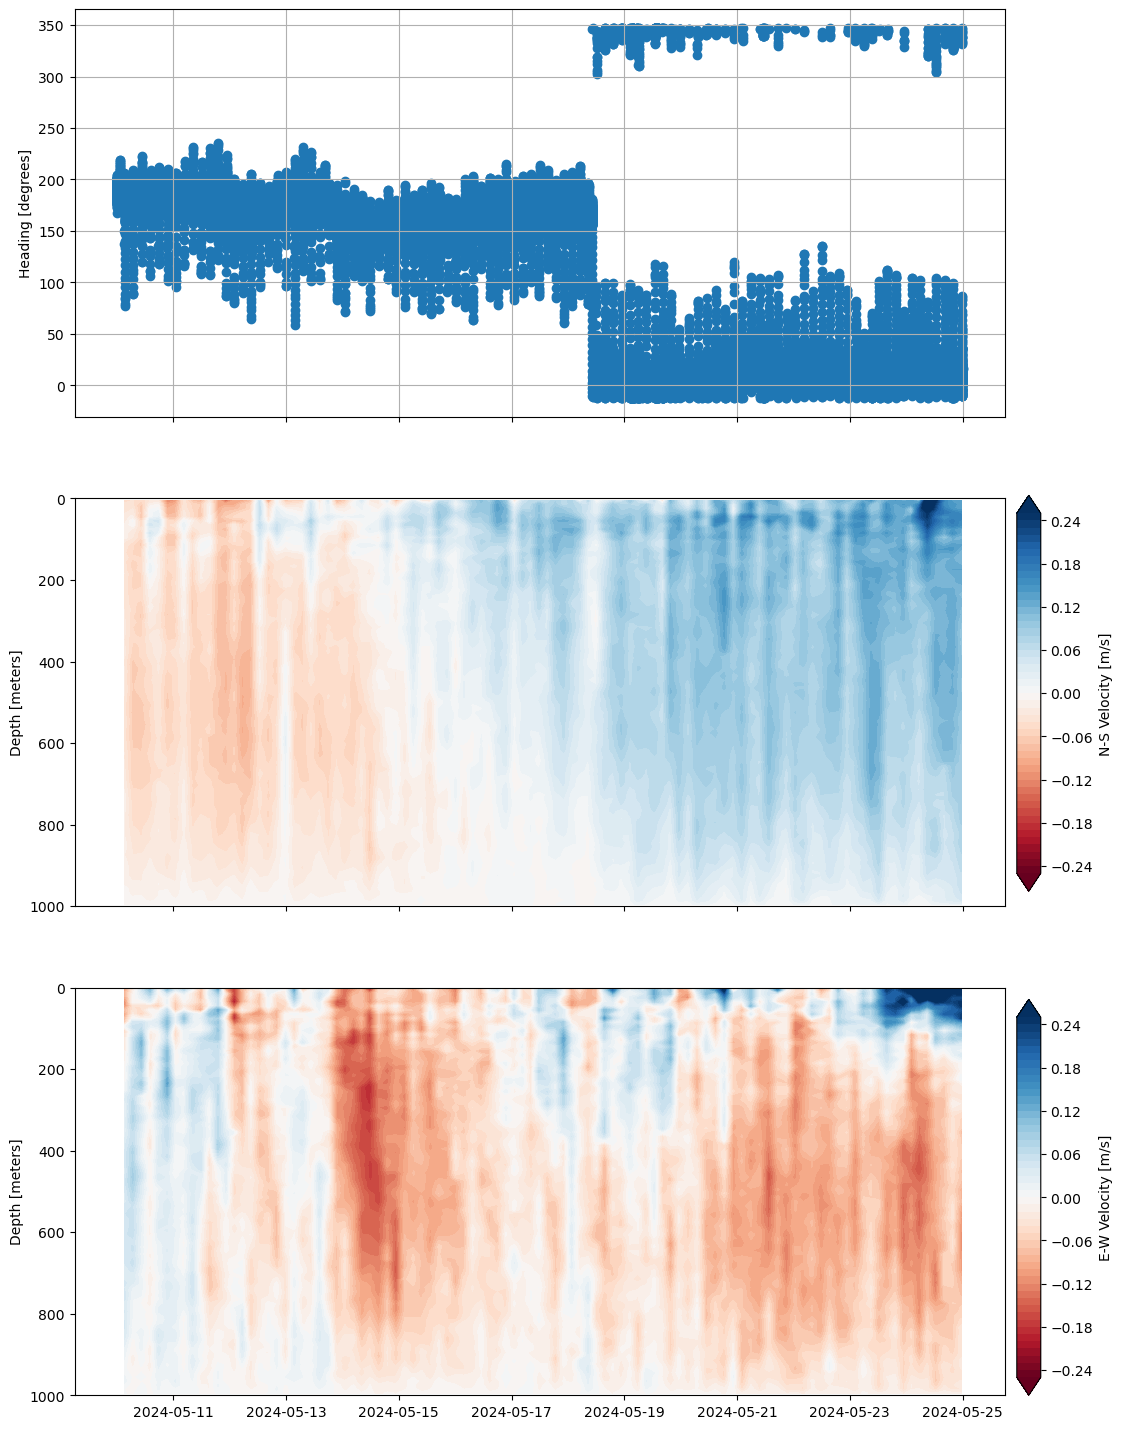

In [4]:

start_time = '2024-05-10'
end_time   = '2024-05-25'

## Subset glider
subset_gdf = gdf[(gdf.time>= start_time) & (gdf.time<=end_time)]

## Subset ad2cp next
start_time = pd.to_datetime(start_time).tz_localize(None)
end_time = pd.to_datetime(end_time).tz_localize(None)
turn_ad2cp = ds.sel(time=slice(start_time,end_time))


fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12,18),nrows=3, sharex=True)


ax1.scatter(subset_gdf.time,subset_gdf.heading)
ax1.grid()
ax1.set_ylabel('Heading [degrees]')



cax = ax2.contourf(turn_ad2cp.time,turn_ad2cp.depth,turn_ad2cp.v_grid,levels=np.arange(-0.25,0.26,0.01),cmap='RdBu',extend='both')
ax2.set_ylim(1000,0)
ax2.set_ylabel('Depth [meters]')

cbar_ax = fig.add_axes([0.91, 0.39, 0.02, 0.22])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label('N-S Velocity [m/s]')


cax = ax3.contourf(turn_ad2cp.time,turn_ad2cp.depth,turn_ad2cp.u_grid,levels=np.arange(-0.25,0.26,0.01),cmap='RdBu',extend='both')
ax3.set_ylim(1000,0)
ax3.set_ylabel('Depth [meters]')

cbar_ax = fig.add_axes([0.91, 0.11, 0.02, 0.22])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label('E-W Velocity [m/s]')


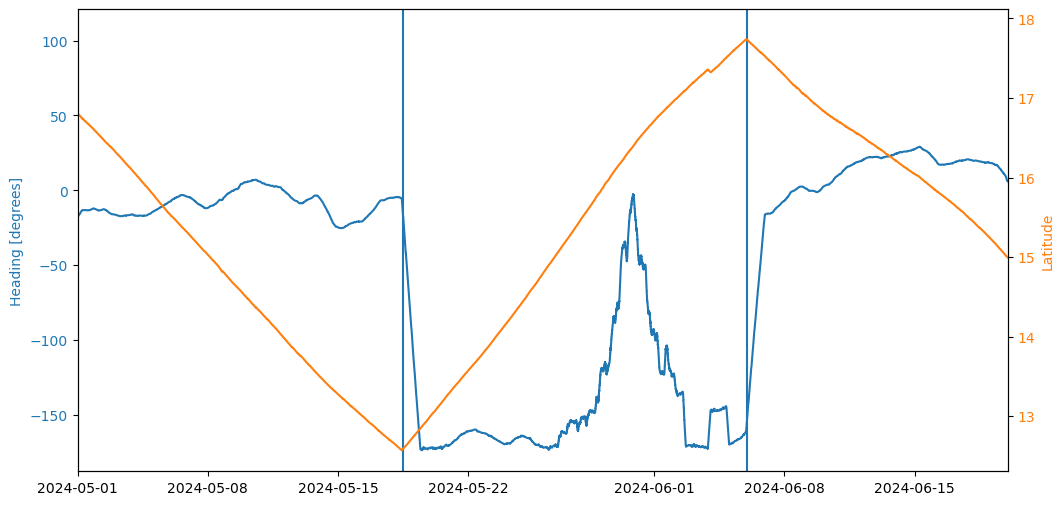

In [5]:
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(gdf.time,gdf.rolling_mean_heading-180,color='tab:blue')
ax.axvline(pd.to_datetime('2024-05-18T12:00:00Z')) ## Transect 1 end time
ax.axvline(pd.to_datetime('2024-06-06T00:00:00Z')) ## ## Transect 2 end time
ax.set_xlim(pd.to_datetime('2024-05-01'),pd.to_datetime('2024-06-20'))
ax.set_ylabel('Heading [degrees]',color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax.twinx()

ax2.plot(gdf.time,gdf.latitude,color='tab:orange')
ax2.set_ylabel('Latitude',color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')


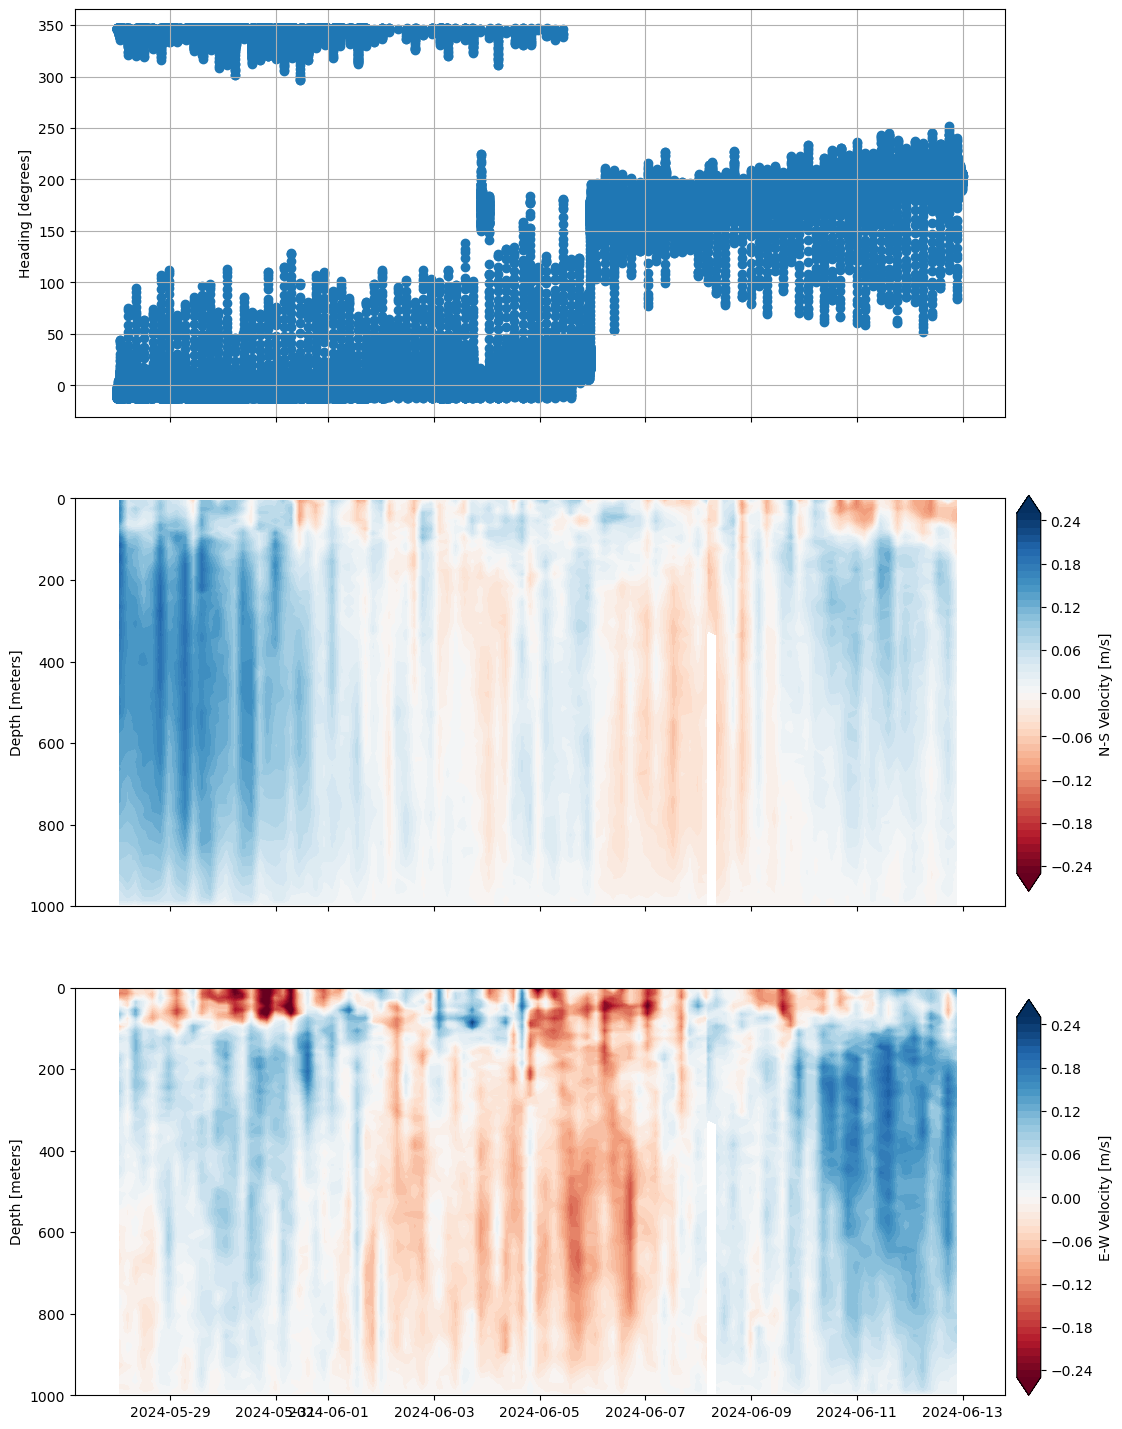

In [6]:

start_time = '2024-05-28'
end_time   = '2024-06-13'


## Subset glider
subset_gdf = gdf[(gdf.time>= start_time) & (gdf.time<=end_time)]

## Subset ad2cp next
start_time = pd.to_datetime(start_time).tz_localize(None)
end_time = pd.to_datetime(end_time).tz_localize(None)
turn_ad2cp = ds.sel(time=slice(start_time,end_time))


fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12,18),nrows=3, sharex=True)


ax1.scatter(subset_gdf.time,subset_gdf.heading)
ax1.grid()
ax1.set_ylabel('Heading [degrees]')



cax = ax2.contourf(turn_ad2cp.time,turn_ad2cp.depth,turn_ad2cp.v_grid,levels=np.arange(-0.25,0.26,0.01),cmap='RdBu',extend='both')
ax2.set_ylim(1000,0)
ax2.set_ylabel('Depth [meters]')

cbar_ax = fig.add_axes([0.91, 0.39, 0.02, 0.22])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label('N-S Velocity [m/s]')


cax = ax3.contourf(turn_ad2cp.time,turn_ad2cp.depth,turn_ad2cp.u_grid,levels=np.arange(-0.25,0.26,0.01),cmap='RdBu',extend='both')
ax3.set_ylim(1000,0)
ax3.set_ylabel('Depth [meters]')

cbar_ax = fig.add_axes([0.91, 0.11, 0.02, 0.22])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label('E-W Velocity [m/s]')


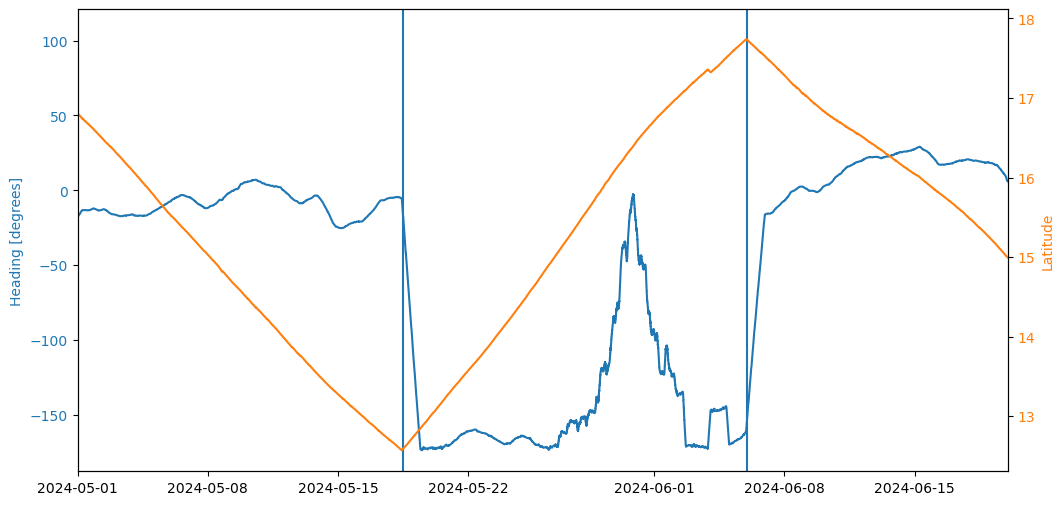

In [7]:
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(gdf.time,gdf.rolling_mean_heading-180,color='tab:blue')
ax.axvline(pd.to_datetime('2024-05-18T12:00:00Z')) ## Transect 1 end time
ax.axvline(pd.to_datetime('2024-06-06T00:00:00Z')) ## ## Transect 2 end time
ax.set_xlim(pd.to_datetime('2024-05-01'),pd.to_datetime('2024-06-20'))
ax.set_ylabel('Heading [degrees]',color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax.twinx()

ax2.plot(gdf.time,gdf.latitude,color='tab:orange')
ax2.set_ylabel('Latitude',color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')


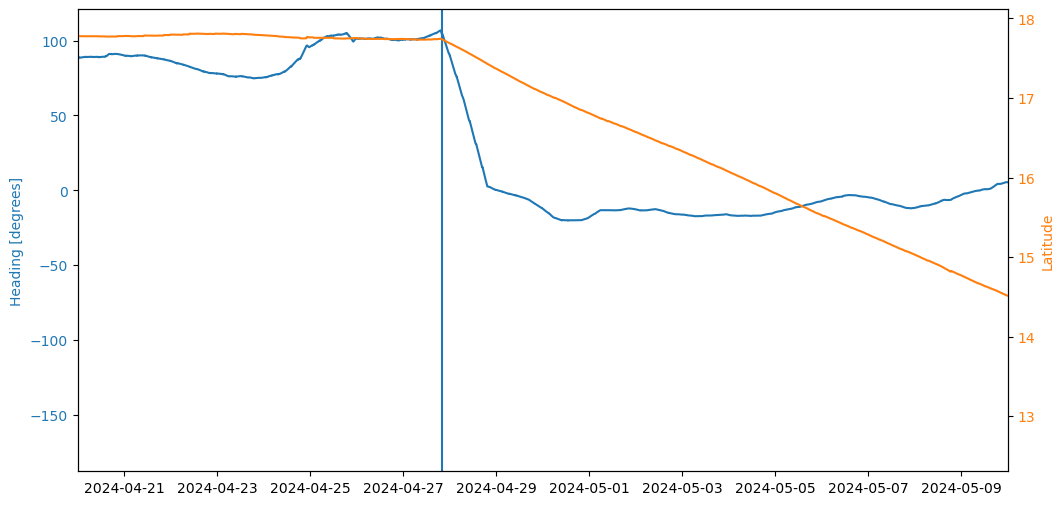

In [8]:

fig,ax = plt.subplots(figsize=(12,6))
ax.plot(gdf.time,gdf.rolling_mean_heading-180,color='tab:blue')
ax.axvline(pd.to_datetime('2024-04-27T20:05:00Z')) ## Transect 1 start time
ax.set_xlim(pd.to_datetime('2024-04-20'),pd.to_datetime('2024-05-10'))
ax.set_ylabel('Heading [degrees]',color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax.twinx()

ax2.plot(gdf.time,gdf.latitude,color='tab:orange')
ax2.set_ylabel('Latitude',color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')


## Transect 2

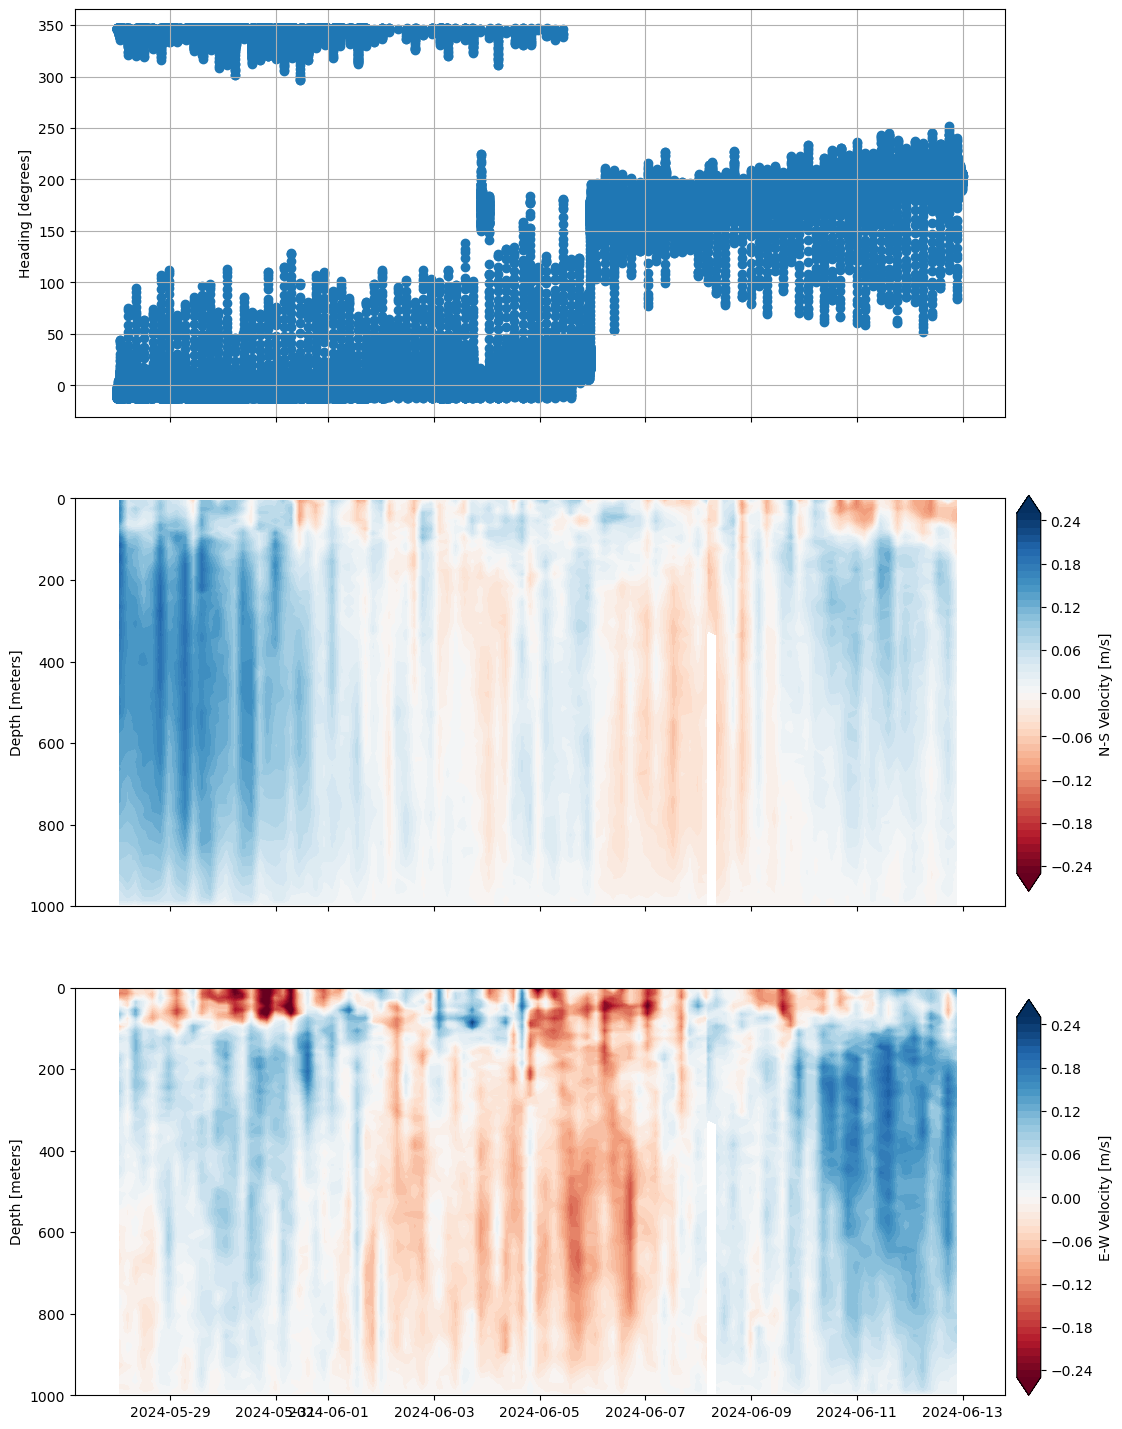

In [9]:

start_time = '2024-05-28'
end_time   = '2024-06-13'


## Subset glider
subset_gdf = gdf[(gdf.time>= start_time) & (gdf.time<=end_time)]

## Subset ad2cp next
start_time = pd.to_datetime(start_time).tz_localize(None)
end_time = pd.to_datetime(end_time).tz_localize(None)
turn_ad2cp = ds.sel(time=slice(start_time,end_time))


fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12,18),nrows=3, sharex=True)


ax1.scatter(subset_gdf.time,subset_gdf.heading)
ax1.grid()
ax1.set_ylabel('Heading [degrees]')



cax = ax2.contourf(turn_ad2cp.time,turn_ad2cp.depth,turn_ad2cp.v_grid,levels=np.arange(-0.25,0.26,0.01),cmap='RdBu',extend='both')
ax2.set_ylim(1000,0)
ax2.set_ylabel('Depth [meters]')

cbar_ax = fig.add_axes([0.91, 0.39, 0.02, 0.22])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label('N-S Velocity [m/s]')


cax = ax3.contourf(turn_ad2cp.time,turn_ad2cp.depth,turn_ad2cp.u_grid,levels=np.arange(-0.25,0.26,0.01),cmap='RdBu',extend='both')
ax3.set_ylim(1000,0)
ax3.set_ylabel('Depth [meters]')

cbar_ax = fig.add_axes([0.91, 0.11, 0.02, 0.22])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label('E-W Velocity [m/s]')


## Subset to transects

In [10]:
## Taken from RU29_ABC2DR_Analysis.ipynb
transect1_start_time = pd.to_datetime('2024-04-27T20:05:00Z').tz_localize(None) ## transect 1 start time
transect1_end_time = pd.to_datetime('2024-05-18T12:00:00Z').tz_localize(None) ## transect 1 end time
transect2_start_time = pd.to_datetime('2024-05-18T12:00:00Z').tz_localize(None) ## transect 2 start time
transect2_end_time = pd.to_datetime('2024-06-06T00:00:00Z').tz_localize(None) ## transect 2 end time

transect1_ds = ds.sel(time=slice(transect1_start_time,transect1_end_time))
transect2_ds = ds.sel(time=slice(transect2_start_time,transect2_end_time))


transect1_ds = calc_segment_transport(transect1_ds)
transect2_ds = calc_segment_transport(transect2_ds)
transect2_ds

<xarray.Dataset> Size: 205kB
Dimensions:            (depth: 100, time: 121)
Coordinates:
  * time               (time) datetime64[ns] 968B 2024-05-18T12:01:06 ... 202...
  * depth              (depth) float64 800B 5.0 15.0 25.0 ... 975.0 985.0 995.0
Data variables:
    u_grid             (depth, time) float64 97kB ...
    v_grid             (depth, time) float64 97kB ...
    latitude           (time) float64 968B ...
    longitude          (time) float64 968B ...
    start_lat          (time) float64 968B ...
    start_lon          (time) float64 968B ...
    end_lat            (time) float64 968B ...
    end_lon            (time) float64 968B ...
    start_time         (time) datetime64[ns] 968B ...
    end_time           (time) datetime64[ns] 968B ...
    segment_transport  (time) float64 968B -1.447e+04 -8.864e+04 ... -3.126e+05
    segment_dist       (time) float64 968B 525.6 4.258e+03 ... 3.916e+03
Attributes:
    description:  RU29 Nortek AD2CP least-squares inversion velocity profile ...

In [11]:
print('Trasect #1 Latitude Range:',np.round(transect1_ds.latitude.min().values,3),'to',np.round(transect1_ds.latitude.max().values,3))
print('Trasect #2 Latitude Range:',np.round(transect2_ds.latitude.min().values,3),'to',np.round(transect2_ds.latitude.max().values,3))


Trasect #1 Latitude Range: 12.602 to 17.739
Trasect #2 Latitude Range: 12.589 to 17.716


Text(0.5, 0, 'Segment Distance (m)')

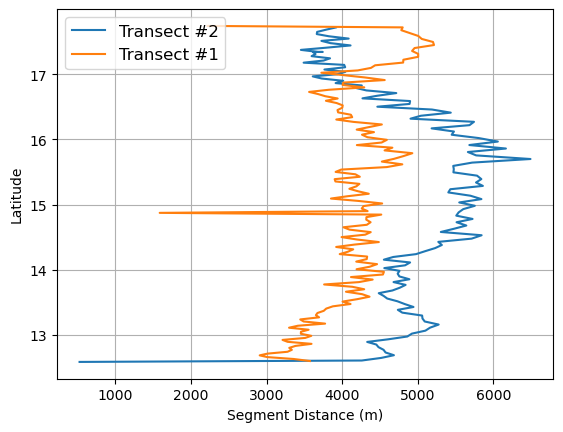

In [12]:
plt.plot(transect2_ds.segment_dist,transect2_ds.latitude,label='Transect #2')
plt.plot(transect1_ds.segment_dist,transect1_ds.latitude,label='Transect #1')
plt.legend(fontsize=fontsize)
plt.grid()
plt.ylabel('Latitude')
plt.xlabel('Segment Distance (m)')

In [13]:
print('Transect 1 Median Segment Distance ',np.round(np.nanmedian(transect1_ds.segment_dist)/1000,2),'km')
print('Transect 2 Median Segment Distance ',np.round(np.nanmedian(transect2_ds.segment_dist)/1000,2),'km')
print('')
print('Transect 1 Mean Segment Distance ',np.round(np.nanmean(transect1_ds.segment_dist)/1000,2),'km')
print('Transect 2 Mean Segment Distance ',np.round(np.nanmean(transect2_ds.segment_dist)/1000,2),'km')

Transect 1 Median Segment Distance  4.17 km
Transect 2 Median Segment Distance  4.83 km

Transect 1 Mean Segment Distance  4.1 km
Transect 2 Mean Segment Distance  4.78 km


In [14]:
# Define your min and max latitudes (in degrees)
min_lat = transect1_ds.latitude.min().values
max_lat = transect1_ds.latitude.max().values

# Define the constant longitude
longitude = -69.0

# 1 degree latitude ≈ 111.32 km
km = 5.5
lat_step_deg = km / 111.32

# Create the latitude grid
lat_grid = np.arange(min_lat, max_lat + lat_step_deg, lat_step_deg)



In [15]:
transect1_ds_interp = interpolate_all_profiles_to_lat_grid(transect1_ds, lat_grid)
transect2_ds_interp = interpolate_all_profiles_to_lat_grid(transect2_ds, lat_grid)
transect1_ds_interp

/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_11981/1556332909.py:136: RuntimeWarning: invalid value encountered in cast
  mean_time = mean_time.astype('int64')


<xarray.Dataset> Size: 176kB
Dimensions:    (depth: 100, latitude: 105)
Coordinates:
  * depth      (depth) float64 800B 5.0 15.0 25.0 35.0 ... 975.0 985.0 995.0
  * latitude   (latitude) float64 840B 12.6 12.65 12.7 ... 17.64 17.69 17.74
    longitude  (latitude) float64 840B -69.0 -69.0 -69.0 ... -69.0 -69.0 -69.0
Data variables:
    u_grid     (depth, latitude) float64 84kB -0.09013 -0.06987 ... 0.001462 nan
    v_grid     (depth, latitude) float64 84kB 0.06303 0.05127 ... -0.004115 nan
    n_profs    (latitude) int64 840B 1 2 2 2 1 2 1 2 2 1 ... 1 1 1 1 1 1 1 1 1 2
    time       (latitude) datetime64[ns] 840B 2024-05-18T08:32:11 ... 2024-04...
    start_lat  (latitude) float64 840B 12.58 12.63 12.68 ... 17.62 17.67 17.72
    end_lat    (latitude) float64 840B 12.63 12.68 12.73 ... 17.67 17.72 17.77
    start_lon  (latitude) float64 840B -69.0 -69.0 -69.0 ... -69.0 -69.0 -69.0
    end_lon    (latitude) float64 840B -69.0 -69.0 -69.0 ... -69.0 -69.0 -69.0

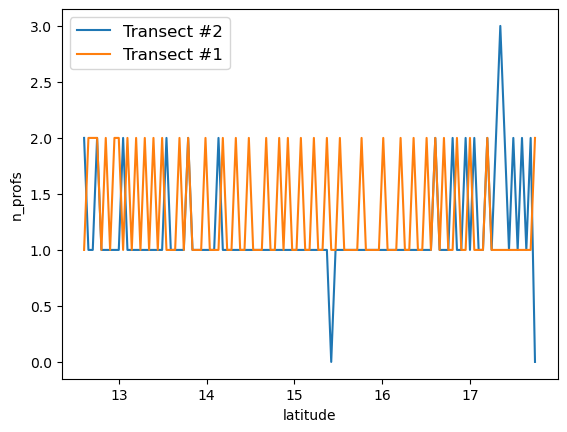

In [16]:
transect2_ds_interp.n_profs.plot(label='Transect #2')
transect1_ds_interp.n_profs.plot(label='Transect #1')
plt.legend(fontsize=fontsize)

Text(0.5, 1.0, 'Transect #1')

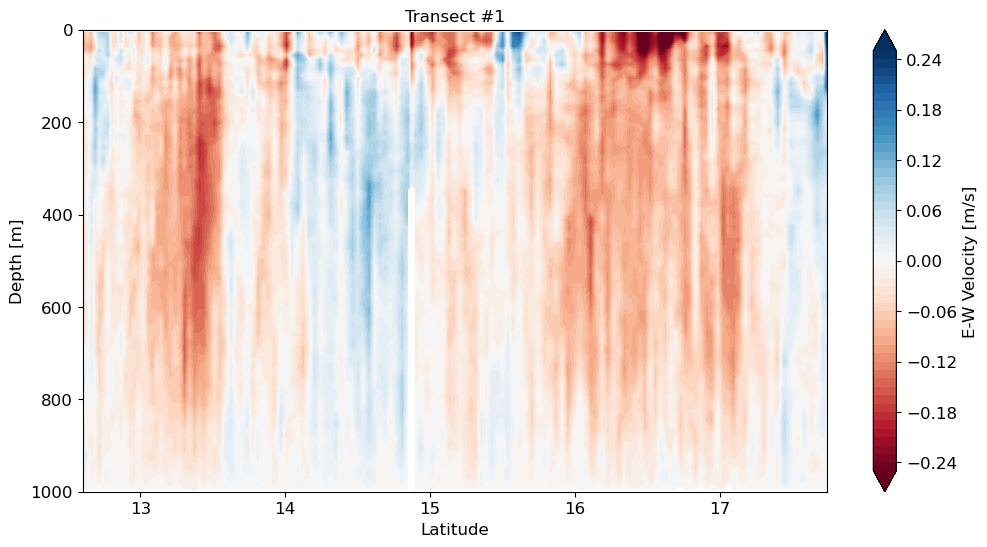

In [17]:
plt.figure(figsize=(12,6))
plt.contourf(transect1_ds.latitude,transect1_ds.depth,transect1_ds.u_grid,levels=np.arange(-0.25,0.26,0.01),cmap='RdBu',extend='both')
plt.ylim(1000,0)

plt.ylabel('Depth [m]',fontsize=fontsize)
plt.xlabel('Latitude',fontsize=fontsize)
cb = plt.colorbar()
cb.set_label(label='E-W Velocity [m/s]',size=fontsize)
cb.ax.tick_params(labelsize=fontsize)
plt.gca().tick_params(axis='both', which='major', labelsize=fontsize)
plt.title('Transect #1',fontsize=fontsize)



Text(0.5, 1.0, 'Transect #1 (Interp)')

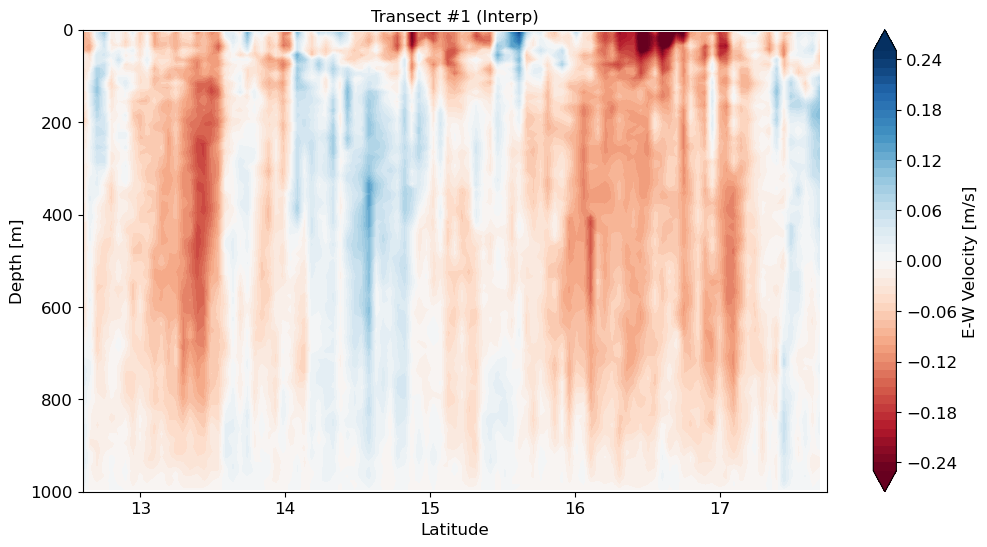

In [18]:
plt.figure(figsize=(12,6))
plt.contourf(transect1_ds_interp.latitude,transect1_ds_interp.depth,transect1_ds_interp.u_grid,levels=np.arange(-0.25,0.26,0.01),cmap='RdBu',extend='both')
plt.ylim(1000,0)

plt.ylabel('Depth [m]',fontsize=fontsize)
plt.xlabel('Latitude',fontsize=fontsize)
cb = plt.colorbar()
cb.set_label(label='E-W Velocity [m/s]',size=fontsize)
cb.ax.tick_params(labelsize=fontsize)
plt.gca().tick_params(axis='both', which='major', labelsize=fontsize)
plt.title('Transect #1 (Interp)',fontsize=fontsize)



Text(0.5, 1.0, 'Transect #1')

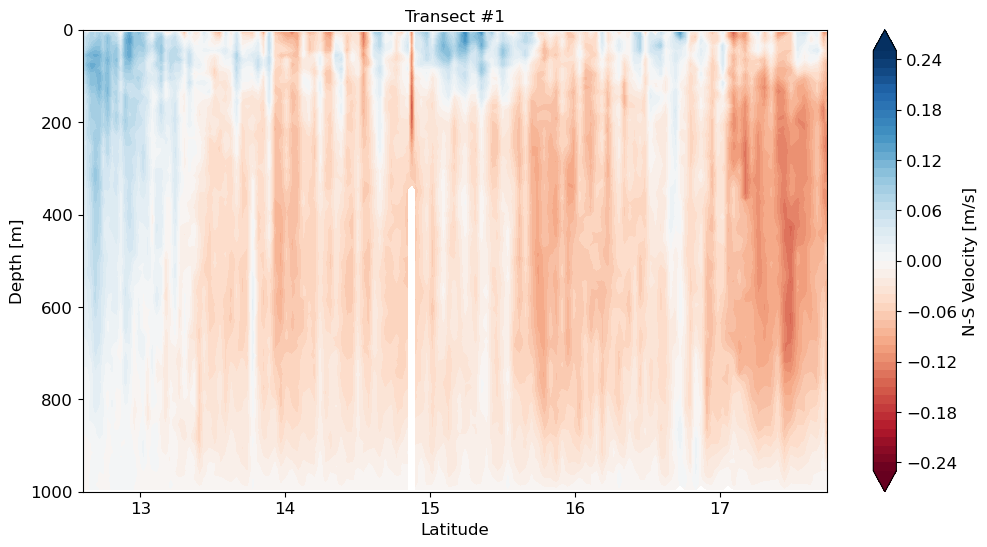

In [19]:
plt.figure(figsize=(12,6))
plt.contourf(transect1_ds.latitude,transect1_ds.depth,transect1_ds.v_grid,levels=np.arange(-0.25,0.26,0.01),cmap='RdBu',extend='both')
plt.ylim(1000,0)


plt.ylabel('Depth [m]',fontsize=fontsize)
plt.xlabel('Latitude',fontsize=fontsize)
cb = plt.colorbar()
cb.set_label(label='N-S Velocity [m/s]',size=fontsize)
cb.ax.tick_params(labelsize=fontsize)
plt.gca().tick_params(axis='both', which='major', labelsize=fontsize)
plt.title('Transect #1',fontsize=fontsize)



Text(0.5, 1.0, 'Transect #1 (Interp)')

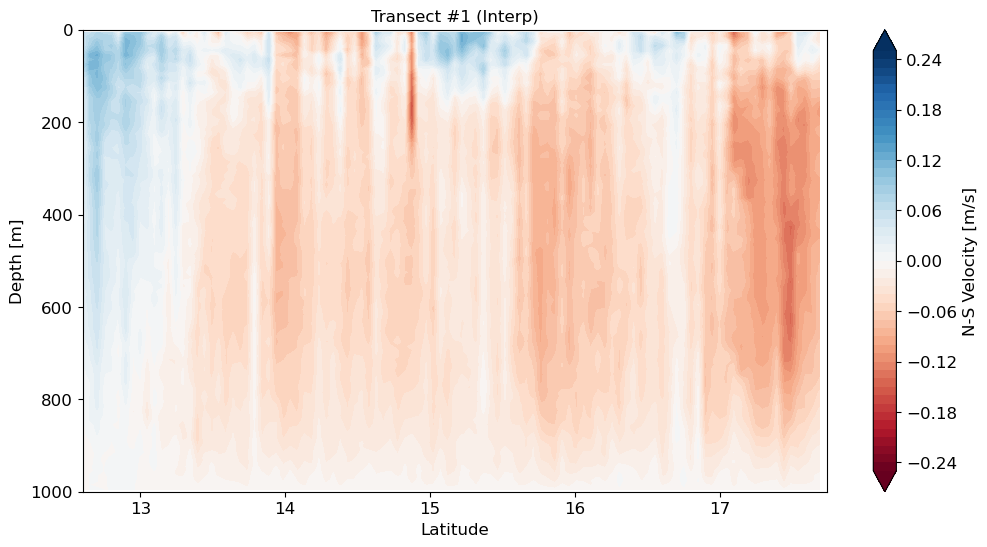

In [20]:
plt.figure(figsize=(12,6))
plt.contourf(transect1_ds_interp.latitude,transect1_ds_interp.depth,transect1_ds_interp.v_grid,levels=np.arange(-0.25,0.26,0.01),cmap='RdBu',extend='both')
plt.ylim(1000,0)


plt.ylabel('Depth [m]',fontsize=fontsize)
plt.xlabel('Latitude',fontsize=fontsize)
cb = plt.colorbar()
cb.set_label(label='N-S Velocity [m/s]',size=fontsize)
cb.ax.tick_params(labelsize=fontsize)
plt.gca().tick_params(axis='both', which='major', labelsize=fontsize)
plt.title('Transect #1 (Interp)',fontsize=fontsize)



Text(0.5, 1.0, 'Transect #2')

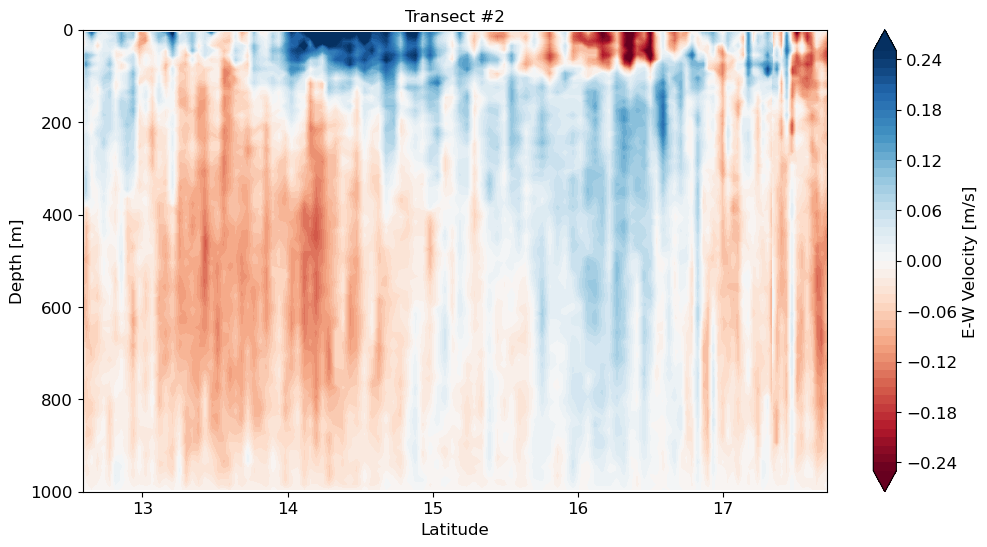

In [21]:
plt.figure(figsize=(12,6))
plt.contourf(transect2_ds.latitude,transect2_ds.depth,transect2_ds.u_grid,levels=np.arange(-0.25,0.26,0.01),cmap='RdBu',extend='both')
plt.ylim(1000,0)

plt.ylabel('Depth [m]',fontsize=fontsize)
plt.xlabel('Latitude',fontsize=fontsize)
cb = plt.colorbar()
cb.set_label(label='E-W Velocity [m/s]',size=fontsize)
cb.ax.tick_params(labelsize=fontsize)
plt.gca().tick_params(axis='both', which='major', labelsize=fontsize)
plt.title('Transect #2',fontsize=fontsize)



Text(0.5, 1.0, 'Transect #2 (Interp)')

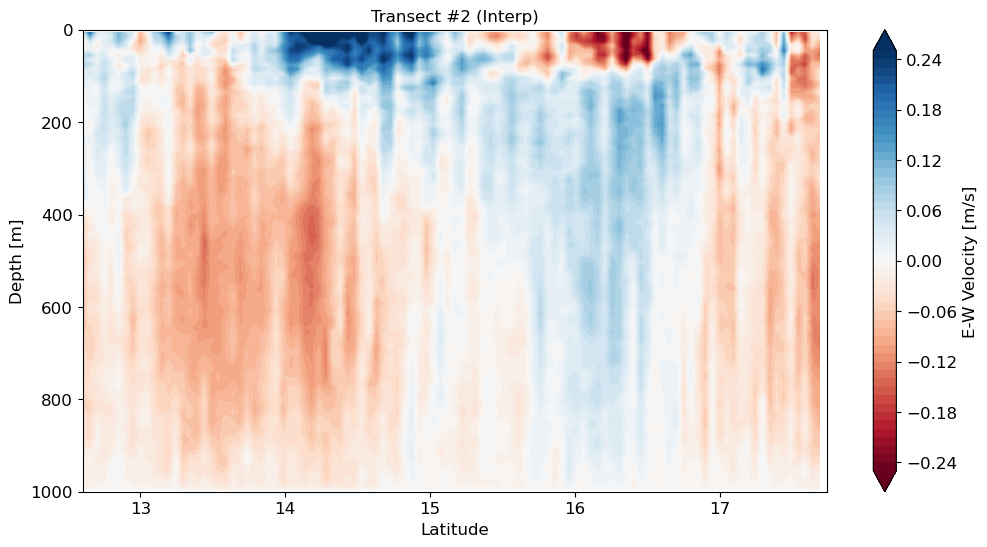

In [22]:
plt.figure(figsize=(12,6))
plt.contourf(transect2_ds_interp.latitude,transect2_ds_interp.depth,transect2_ds_interp.u_grid,levels=np.arange(-0.25,0.26,0.01),cmap='RdBu',extend='both')
plt.ylim(1000,0)

plt.ylabel('Depth [m]',fontsize=fontsize)
plt.xlabel('Latitude',fontsize=fontsize)
cb = plt.colorbar()
cb.set_label(label='E-W Velocity [m/s]',size=fontsize)
cb.ax.tick_params(labelsize=fontsize)
plt.gca().tick_params(axis='both', which='major', labelsize=fontsize)
plt.title('Transect #2 (Interp)',fontsize=fontsize)



Text(0.5, 1.0, 'Transect #2')

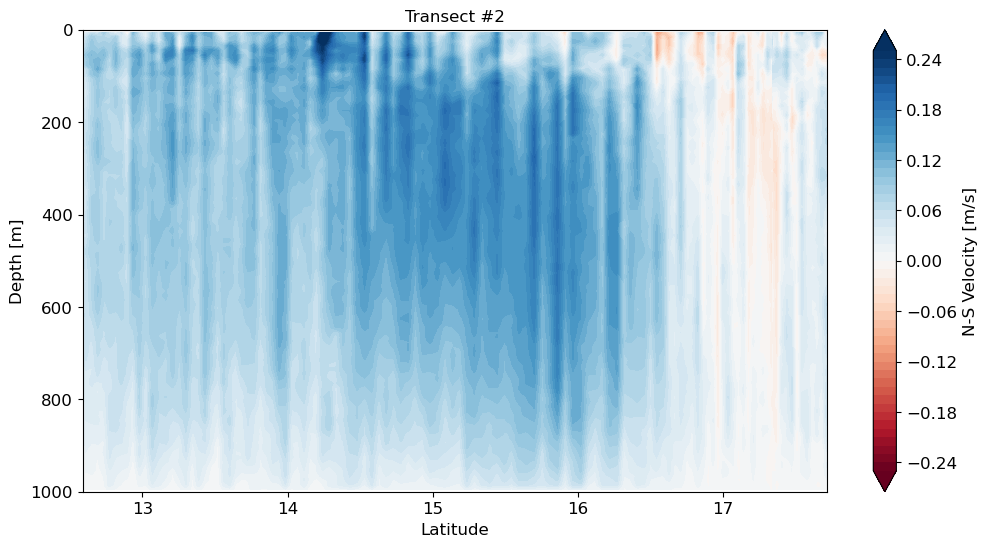

In [23]:
plt.figure(figsize=(12,6))
plt.contourf(transect2_ds.latitude,transect2_ds.depth,transect2_ds.v_grid,levels=np.arange(-0.25,0.26,0.01),cmap='RdBu',extend='both')
plt.ylim(1000,0)

plt.ylabel('Depth [m]',fontsize=fontsize)
plt.xlabel('Latitude',fontsize=fontsize)
cb = plt.colorbar()
cb.set_label(label='N-S Velocity [m/s]',size=fontsize)
cb.ax.tick_params(labelsize=fontsize)
plt.gca().tick_params(axis='both', which='major', labelsize=fontsize)
plt.title('Transect #2',fontsize=fontsize)



Text(0.5, 1.0, 'Transect #2 (Interp)')

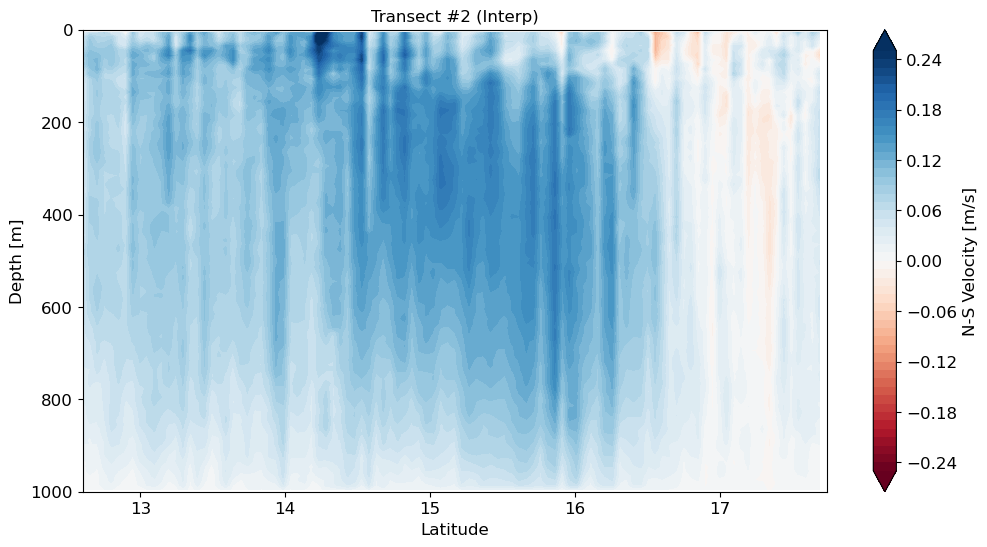

In [24]:
plt.figure(figsize=(12,6))
plt.contourf(transect2_ds_interp.latitude,transect2_ds_interp.depth,transect2_ds_interp.v_grid,levels=np.arange(-0.25,0.26,0.01),cmap='RdBu',extend='both')
plt.ylim(1000,0)

plt.ylabel('Depth [m]',fontsize=fontsize)
plt.xlabel('Latitude',fontsize=fontsize)
cb = plt.colorbar()
cb.set_label(label='N-S Velocity [m/s]',size=fontsize)
cb.ax.tick_params(labelsize=fontsize)
plt.gca().tick_params(axis='both', which='major', labelsize=fontsize)
plt.title('Transect #2 (Interp)',fontsize=fontsize)



## Calculate transport

In [25]:
transect1_ds = calc_segment_transport(transect1_ds)
transect2_ds = calc_segment_transport(transect2_ds)

transect1_ds_interp = calc_segment_transport_interp(transect1_ds_interp)
transect2_ds_interp = calc_segment_transport_interp(transect2_ds_interp)


In [26]:
print('Transect #1 Transport',np.nansum(transect1_ds.segment_transport)/(10**6),'Sv')
print('Transect #2 Transport',np.nansum(transect2_ds.segment_transport)/(10**6),'Sv')

print('Transect #1 Interp Transport',np.nansum(transect1_ds_interp.segment_transport)/(10**6),'Sv')
print('Transect #2 Interp Transport',np.nansum(transect2_ds_interp.segment_transport)/(10**6),'Sv')


Transect #1 Transport -17.63937929556431 Sv
Transect #2 Transport -9.222732270000174 Sv
Transect #1 Interp Transport -17.85998456190231 Sv
Transect #2 Interp Transport -9.030091922846363 Sv


## Difference between the two transects

In [27]:
transect_diff = transect1_ds_interp-transect2_ds_interp
transect_diff

<xarray.Dataset> Size: 177kB
Dimensions:            (depth: 100, latitude: 105)
Coordinates:
  * depth              (depth) float64 800B 5.0 15.0 25.0 ... 975.0 985.0 995.0
  * latitude           (latitude) float64 840B 12.6 12.65 12.7 ... 17.69 17.74
    longitude          (latitude) float64 840B -69.0 -69.0 -69.0 ... -69.0 -69.0
Data variables:
    u_grid             (depth, latitude) float64 84kB -0.09991 -0.2524 ... nan
    v_grid             (depth, latitude) float64 84kB 0.04867 0.002284 ... nan
    n_profs            (latitude) int64 840B -1 1 1 0 0 1 0 ... 0 -1 0 -1 0 -1 2
    time               (latitude) timedelta64[ns] 840B -1 days +18:46:52.5000...
    start_lat          (latitude) float64 840B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    end_lat            (latitude) float64 840B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    start_lon          (latitude) float64 840B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    end_lon            (latitude) float64 840B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    segment_transport  (latitude) float64 840B -836.1 7.806e+04 ... 0.0
    segment_dist       (latitude) float64 840B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

Text(0.5, 1.0, 'Transect #1-Transect #2')

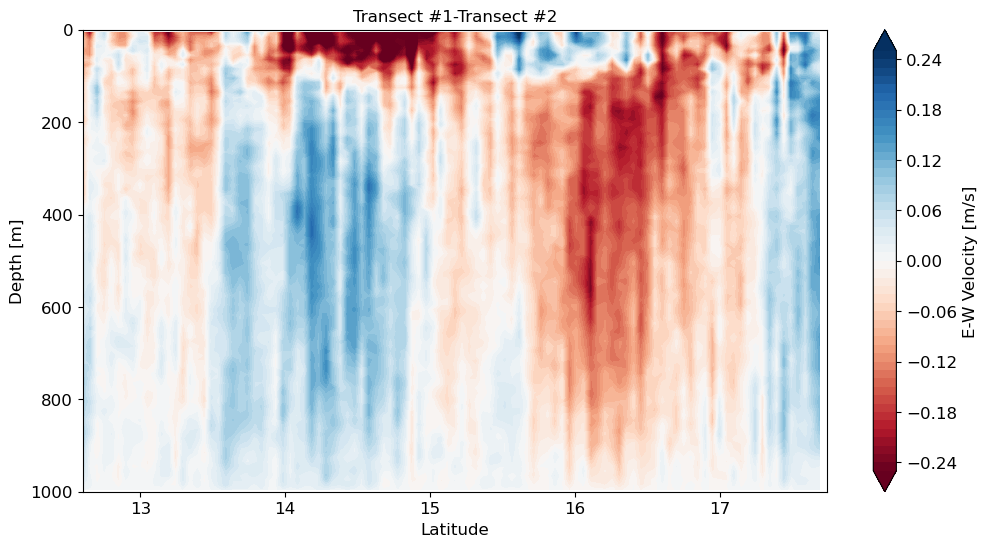

In [28]:
plt.figure(figsize=(12,6))
plt.contourf(transect_diff.latitude,transect_diff.depth,transect_diff.u_grid,levels=np.arange(-0.25,0.26,0.01),cmap='RdBu',extend='both')
plt.ylim(1000,0)

plt.ylabel('Depth [m]',fontsize=fontsize)
plt.xlabel('Latitude',fontsize=fontsize)
cb = plt.colorbar()
cb.set_label(label='E-W Velocity [m/s]',size=fontsize)
cb.ax.tick_params(labelsize=fontsize)
plt.gca().tick_params(axis='both', which='major', labelsize=fontsize)
plt.title('Transect #1-Transect #2',fontsize=fontsize)



Text(0.5, 1.0, 'Segment Transport Difference (Transect #1 - Transect #2)')

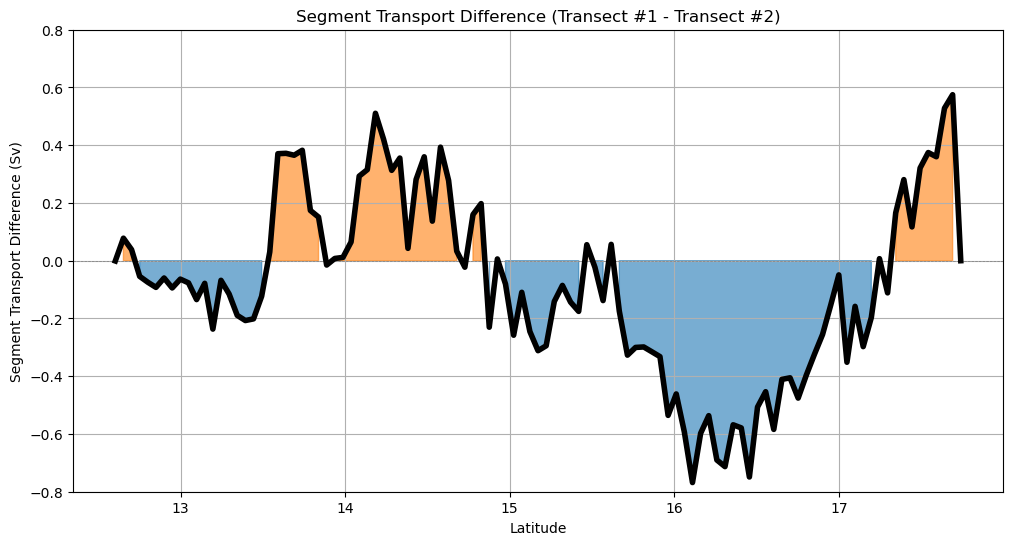

In [29]:

# Extract variables
lat = transect_diff.latitude
transport = transect_diff.segment_transport / 1e6  # convert to Sv

# Create mask arrays
pos_mask = transport > 0
neg_mask = transport < 0

plt.figure(figsize=(12,6))
# Plot baseline
plt.axhline(0, color='grey', linestyle='--',linewidth=0.5)

plt.plot(lat, transport, color='black',linewidth=4)
# Fill positive (orange)
plt.fill_between(lat, 0, transport, where=pos_mask, color='tab:orange', alpha=0.6)

# Fill negative (blue)
plt.fill_between(lat, 0, transport, where=neg_mask, color='tab:blue', alpha=0.6)

# Set y-limits
plt.ylim(-0.8, 0.8)
plt.grid()

plt.xlabel('Latitude')
plt.ylabel('Segment Transport Difference (Sv)')
plt.title('Segment Transport Difference (Transect #1 - Transect #2)', fontsize=fontsize)



## Save interpolated transects

In [31]:
# transect1_ds_interp.to_netcdf('../data/processed_nc/RU29_2024_Processed_AD2CP_Transect1_Interpolated.nc')


In [ ]:
# transect2_ds_interp.to_netcdf('../data/processed_nc/RU29_2024_Processed_AD2CP_Transect2_Interpolated.nc')


## Load gridded glider hydrographic data for contouring isopycnals

In [ ]:
gds = xr.open_dataset('../data/processed_nc/RU29_2024_depth_gridded_glider.nc')
## Taken from RU29_ABC2DR_Analysis.ipynb
transect1_start_time = pd.to_datetime('2024-04-27T20:05:00Z').tz_localize(None) ## transect 1 start time
transect1_end_time = pd.to_datetime('2024-05-18T12:00:00Z').tz_localize(None) ## transect 1 end time
transect2_start_time = pd.to_datetime('2024-05-18T12:00:00Z').tz_localize(None) ## transect 2 start time
transect2_end_time = pd.to_datetime('2024-06-06T00:00:00Z').tz_localize(None) ## transect 2 end time

transect1_gds = gds.sel(time=slice(transect1_start_time,transect1_end_time))
transect2_gds = gds.sel(time=slice(transect2_start_time,transect2_end_time))

# Smooth rho field
sigma_smooth1 = gaussian_filter(transect1_gds.sigma, sigma=1.5)
sigma_smooth2 = gaussian_filter(transect2_gds.sigma, sigma=1.5)


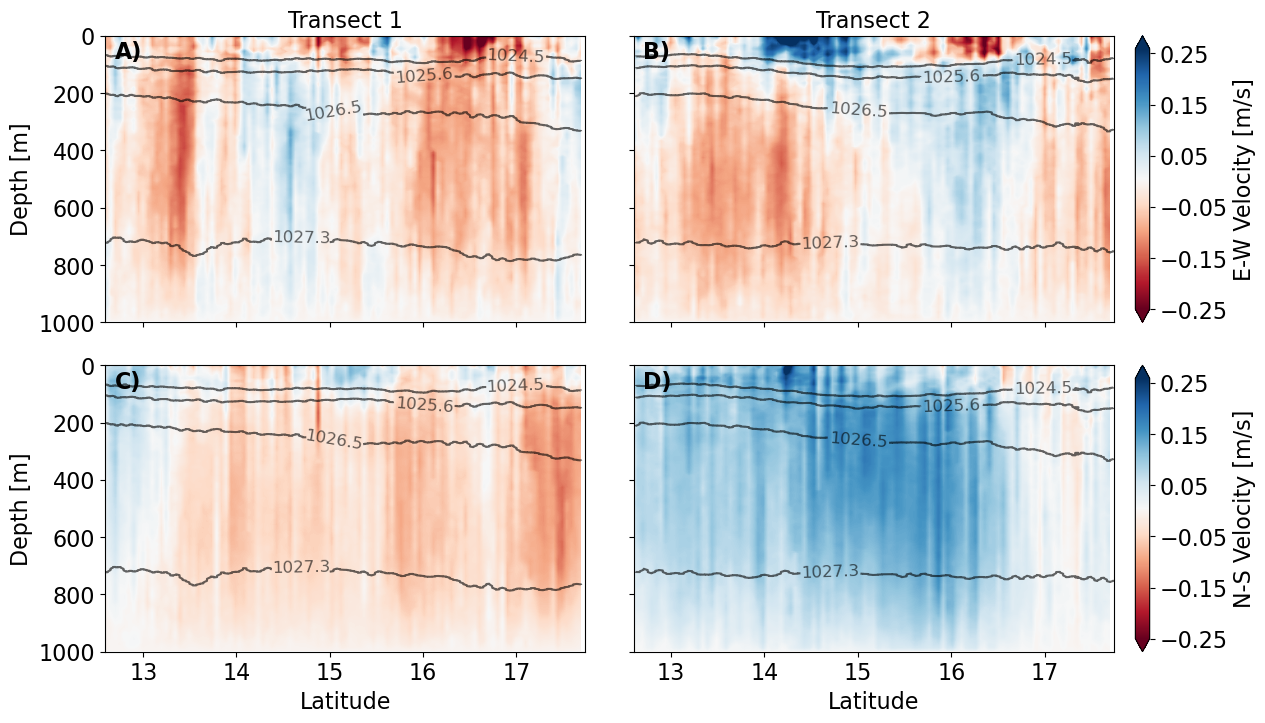

In [70]:

fontsize = 16
levels = np.arange(-0.25, 0.26, 0.001)
cmap = 'RdBu'

fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharex='col', sharey='row')
plt.subplots_adjust(wspace=0.1, hspace=0.15, right=0.88)  # Space for colorbars

# --- Top Left: Transect 1, E-W ---
cf1 = axs[0, 0].contourf(
    transect1_ds_interp.latitude,
    transect1_ds_interp.depth,
    transect1_ds_interp.u_grid,
    levels=levels,
    cmap=cmap,
    extend='both'
)
# Make contour plot
CS = axs[0, 0].contour(
    transect1_gds.latitude,
    transect1_gds.depth,
    sigma_smooth1,
    levels=[1024.5,1025.6,1026.5,1027.3],
    colors='black',
    alpha=0.6
)
# Add contour labels
axs[0, 0].clabel(CS, inline=True, fontsize=12, fmt="%.1f",manual=[(17, 100), (16, 150), (15, 300), (14.7, 700)])

axs[0, 0].set_ylim(1000, 0)
axs[0, 0].set_ylabel('Depth [m]', fontsize=fontsize)
axs[0, 0].set_title('Transect 1', fontsize=fontsize)
axs[0, 0].tick_params(labelsize=fontsize)
axs[0, 0].text(0.02,0.92,'A)', transform=axs[0,0].transAxes, size=fontsize, weight='bold')


# --- Top Right: Transect 2, E-W ---
cf2 = axs[0, 1].contourf(
    transect2_ds_interp.latitude,
    transect2_ds_interp.depth,
    transect2_ds_interp.u_grid,
    levels=levels,
    cmap=cmap,
    extend='both'
)
axs[0, 1].set_ylim(1000, 0)
axs[0, 1].set_title('Transect 2', fontsize=fontsize)
axs[0, 1].tick_params(labelsize=fontsize)
axs[0, 1].text(0.02,0.92,'B)', transform=axs[0,1].transAxes, size=fontsize, weight='bold')

# Make contour plot
CS = axs[0, 1].contour(
    transect2_gds.latitude,
    transect2_gds.depth,
    sigma_smooth2,
    levels=[1024.5,1025.6,1026.5,1027.3],
    colors='black',
    alpha=0.6
)
# Add contour labels
axs[0, 1].clabel(CS, inline=True, fontsize=12, fmt="%.1f",manual=[(17, 100), (16, 150), (15, 300), (14.7, 700)])


# --- Bottom Left: Transect 1, N-S ---
cf3 = axs[1, 0].contourf(
    transect1_ds_interp.latitude,
    transect1_ds_interp.depth,
    transect1_ds_interp.v_grid,
    levels=levels,
    cmap=cmap,
    extend='both'
)
axs[1, 0].set_ylim(1000, 0)
axs[1, 0].set_xlabel('Latitude', fontsize=fontsize)
axs[1, 0].set_ylabel('Depth [m]', fontsize=fontsize)
axs[1, 0].tick_params(labelsize=fontsize)
axs[1, 0].text(0.02,0.92,'C)', transform=axs[1,0].transAxes, size=fontsize, weight='bold')
# Make contour plot
CS = axs[1, 0].contour(
    transect1_gds.latitude,
    transect1_gds.depth,
    sigma_smooth1,
    levels=[1024.5,1025.6,1026.5,1027.3],
    colors='black',
    alpha=0.6
)
# Add contour labels
axs[1, 0].clabel(CS, inline=True, fontsize=12, fmt="%.1f",manual=[(17, 100), (16, 150), (15, 300), (14.7, 700)])


# --- Bottom Right: Transect 2, N-S ---
cf4 = axs[1, 1].contourf(
    transect2_ds_interp.latitude,
    transect2_ds_interp.depth,
    transect2_ds_interp.v_grid,
    levels=levels,
    cmap=cmap,
    extend='both'
)
axs[1, 1].set_ylim(1000, 0)
axs[1, 1].set_xlabel('Latitude', fontsize=fontsize)
axs[1, 1].tick_params(labelsize=fontsize)
axs[1, 1].text(0.02,0.92,'D)', transform=axs[1,1].transAxes, size=fontsize, weight='bold')
# Make contour plot
CS = axs[1, 1].contour(
    transect2_gds.latitude,
    transect2_gds.depth,
    sigma_smooth2,
    levels=[1024.5,1025.6,1026.5,1027.3],
    colors='black',
    alpha=0.6
)
# Add contour labels
axs[1, 1].clabel(CS, inline=True, fontsize=12, fmt="%.1f",manual=[(17, 100), (16, 150), (15, 300), (14.7, 700)])


# --- Colorbar: E-W Velocity (top row) ---
cbar_u = fig.colorbar(cf2, ax=axs[0, :], orientation='vertical', fraction=0.025, pad=0.02)
cbar_u.set_label('E-W Velocity [m/s]', fontsize=fontsize)
cbar_u.set_ticks(np.round(np.linspace(-0.25, 0.25, 6), 2))
cbar_u.ax.tick_params(labelsize=fontsize)

# --- Colorbar: N-S Velocity (bottom row) ---
cbar_v = fig.colorbar(cf4, ax=axs[1, :], orientation='vertical', fraction=0.025, pad=0.02)
cbar_v.set_label('N-S Velocity [m/s]', fontsize=fontsize)
cbar_v.set_ticks(np.round(np.linspace(-0.25, 0.25, 6), 2))
cbar_v.ax.tick_params(labelsize=fontsize)


plt.savefig('../figures/RU29_2024_ABC2DR_Transect_1_2_EW_NS_Velocity_4_Panel.png',dpi=300, bbox_inches='tight')
